In [134]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


21 the best

In [65]:
!cp drive/MyDrive/Google_Stock_Price_Test.csv .
!cp drive/MyDrive/Google_Stock_Price_Train.csv .

In [377]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import load_model
from keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from keras.optimizers import Adam
from keras.layers.experimental.preprocessing import Normalization
from keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, Conv1D, MaxPool1D, Flatten, InputLayer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")
%matplotlib inline

In [136]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
df_train = pd.read_csv('Google_Stock_Price_Train.csv')
data = pd.concat([df_train, df_test])

In [137]:
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 69.9+ KB


Выберем open 

In [139]:
data = data.set_index('Date')
data =data['Open']
data

Date
1/3/2012     325.25
1/4/2012     331.27
1/5/2012     329.83
1/6/2012     328.34
1/9/2012     322.04
              ...  
1/25/2017    829.62
1/26/2017    837.81
1/27/2017    834.71
1/30/2017    814.66
1/31/2017    796.86
Name: Open, Length: 1278, dtype: float64

In [140]:
len(data.index) - len(data.index.unique())

0

Повторов нет 

In [141]:
data.isnull().unique()

array([False])

Пропусков тоже

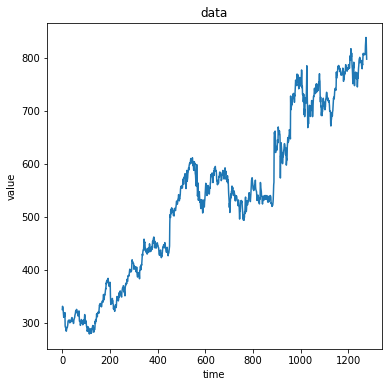

In [142]:
plt.figure(figsize = (6,6))
plt.plot(data.values)
plt.xlabel('time')
plt.ylabel('value')
plt.title('data')
plt.show();

In [143]:
data.describe()

count    1278.000000
mean      537.994906
std       154.508365
min       279.120000
25%       406.037500
50%       538.395000
75%       668.862500
max       837.810000
Name: Open, dtype: float64

Пiдготувати початковi часовi ряди. Розбити їх на навчальний i тестовий
набори у спiввiдношеннi 1:3, вiдповiдно.

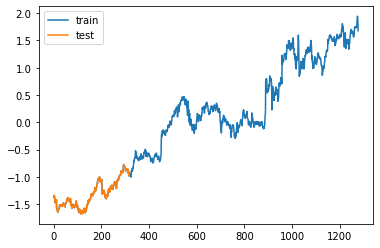

In [144]:
part = len(data) //4

scaler = Normalization()
scaler.adapt(data.values)
data_scaled = scaler(data)

plt.plot(data_scaled, label='train')
plt.plot(data_scaled[:part], label='test')
plt.legend();

Побудувати першу модель, використовуючи один шар базових рекурентних нейронiв, та аналогiчнi моделi iз одним шаром комiрок LSTM i GRU

In [145]:
def split(data, timestamps, y_len):
  n = len(data) - timestamps - y_len  + 1
  X = [data[i:i+timestamps] for i in range(n)]
  Y = [data[i:i+y_len] for i in range(timestamps, n+timestamps)]
  return np.array(X).reshape(-1, timestamps, 1), np.array(Y).reshape(-1, y_len)

In [296]:
def res(history, model):
  history = history.history

  plt.figure(figsize = (18, 6))
  
  plt.subplot(1,3,1)
  plt.plot(history['loss'], label = f"train: {history['loss'][-1]:.4f}")
  plt.plot(history['val_loss'], label=f"val: {history['val_loss'][-1]:.4f}")
  plt.title('MSE')
  plt.legend()

  plt.subplot(1,3,2)
  plt.plot(history['mae'], label = f"train: {history['mae'][-1]:.4f}")
  plt.plot(history['val_mae'], label=f"val: {history['val_mae'][-1]:.4f}")
  plt.title('MAE')
  plt.legend()

  plt.subplot(1,3,3)
  plt.plot(history['mape'], label = f"train: {history['mape'][-1]:.4f}")
  plt.plot(history['val_mape'], label=f"val: {history['val_mape'][-1]:.4f}")
  plt.title('MAPE')
  plt.legend()
  plt.show();

  train_pred = model.predict(X_train)
  val_pred = model.predict(X_val)

  plt.figure(figsize = (18, 6))
  plt.plot(np.vstack([y_train, y_val]), label="Real")
  plt.plot(np.vstack([train_pred, val_pred]), label="val_predict")
  plt.plot(train_pred, label="train_predict")
  plt.xlabel('time')
  plt.ylabel('value')
  plt.title('data')
  plt.legend()
  plt.show();

In [308]:
timestamps=50
y_len=1

In [309]:
X_train, y_train = split(data_scaled[:part], timestamps, y_len)
X_val, y_val = split(data_scaled[part-timestamps: ], timestamps, y_len)

**simplex_model_32**

In [300]:
model1 = Sequential(name = 'simplex_model_32')
model1.add(InputLayer((None, 1)))
model1.add(SimpleRNN(32))
model1.add(Dense(1))
model1.summary()

Model: "simplex_model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 32)                1088      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [301]:
model1.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])

In [302]:
with tf.device('/device:GPU:0'):
  history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
9/9 [==============================] - 3s 147ms/step - loss: 1.1214 - mae: 0.9589 - mape: 72.7219 - val_loss: 0.0964 - val_mae: 0.2619 - val_mape: 668.3064
Epoch 2/50
9/9 [==============================] - 1s 86ms/step - loss: 0.0485 - mae: 0.1839 - mape: 15.6008 - val_loss: 0.1083 - val_mae: 0.2686 - val_mape: 843.7533
Epoch 3/50
9/9 [==============================] - 1s 69ms/step - loss: 0.0554 - mae: 0.2003 - mape: 17.8972 - val_loss: 0.0574 - val_mae: 0.2008 - val_mape: 461.8820
Epoch 4/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0158 - mae: 0.1007 - mape: 7.8097 - val_loss: 0.0620 - val_mae: 0.2041 - val_mape: 642.7533
Epoch 5/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0170 - mae: 0.1052 - mape: 7.7541 - val_loss: 0.0593 - val_mae: 0.1986 - val_mape: 729.0438
Epoch 6/50
9/9 [==============================] - 1s 84ms/step - loss: 0.0102 - mae: 0.0849 - mape: 7.5769 - val_loss: 0.0611 - val_mae: 0.1988 - val_mape: 850.0374
Epoch 

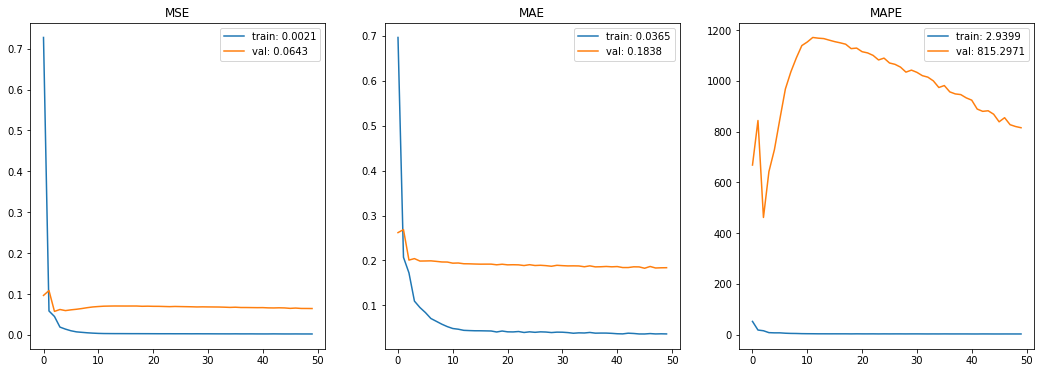

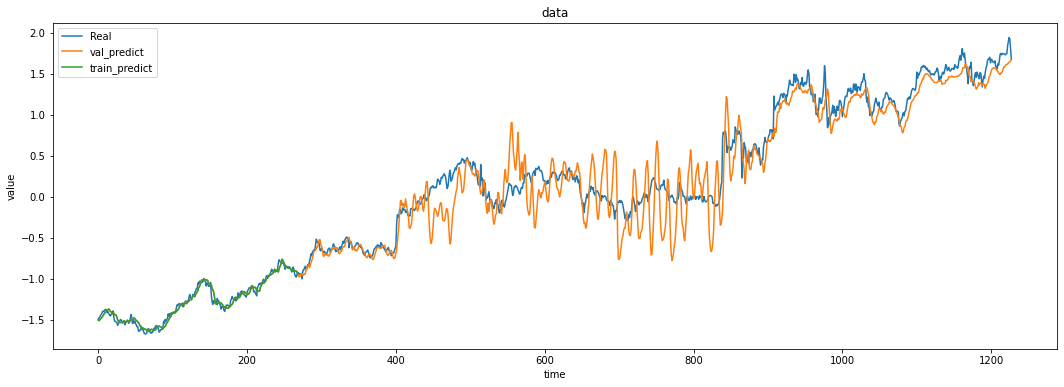

In [303]:
res(history, model1)

**simplex_model_64**

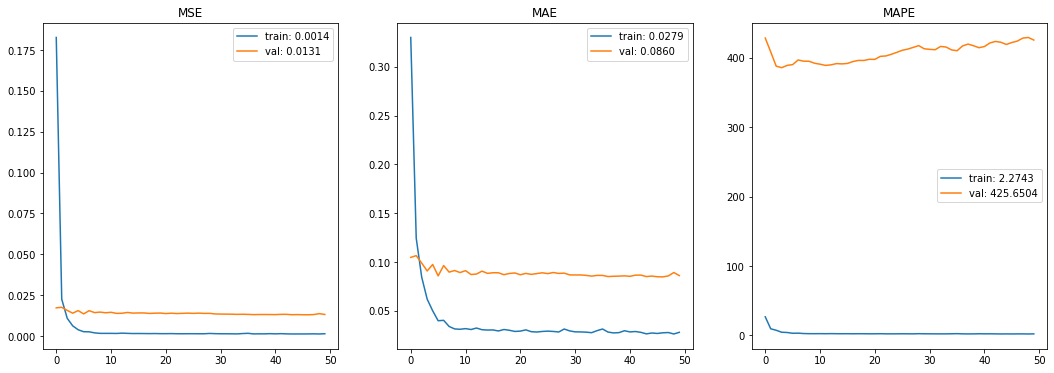

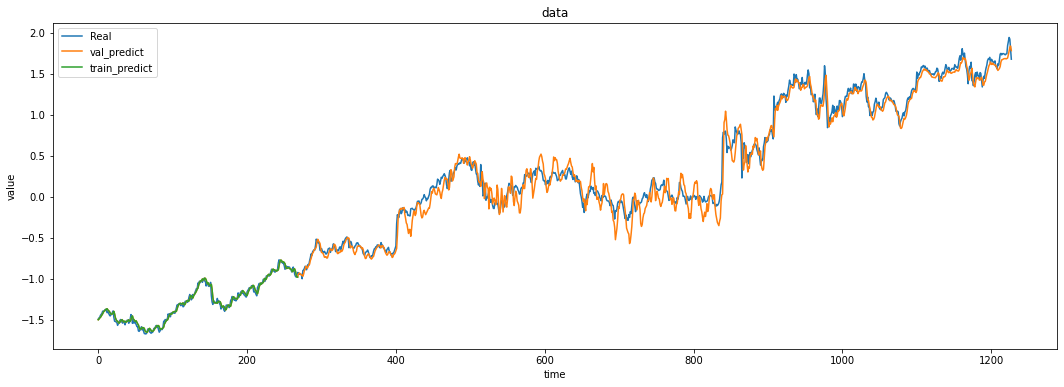

In [310]:
model2 = Sequential(name = 'simplex_model_64')
model2.add(InputLayer((None, 1)))
model2.add(SimpleRNN(64))
model2.add(Dense(1))
model2.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history2 = model2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history2, model2)

Уменьшим окно

In [311]:
timestamps=32
y_len=1

In [312]:
X_train, y_train = split(data_scaled[:part], timestamps, y_len)
X_val, y_val = split(data_scaled[part-timestamps: ], timestamps, y_len)

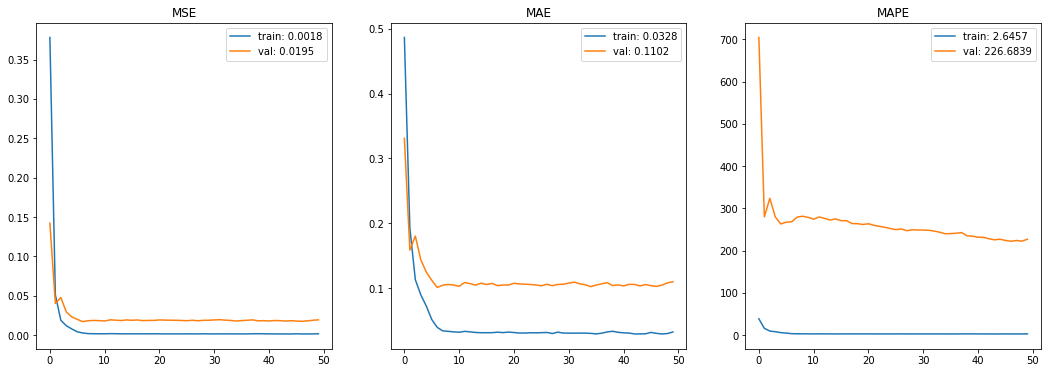

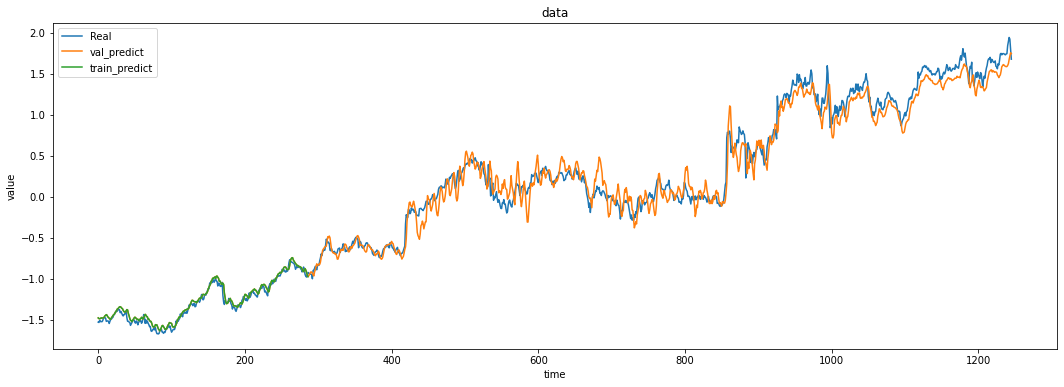

In [314]:
model3 = Sequential(name = 'simplex_model_64')
model3.add(InputLayer((None, 1)))
model3.add(SimpleRNN(64))
model3.add(Dense(1))
model3.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history3 = model3.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history3, model3)

Увеличем окно

In [316]:
timestamps=64
y_len=1
X_train, y_train = split(data_scaled[:part], timestamps, y_len)
X_val, y_val = split(data_scaled[part-timestamps: ], timestamps, y_len)

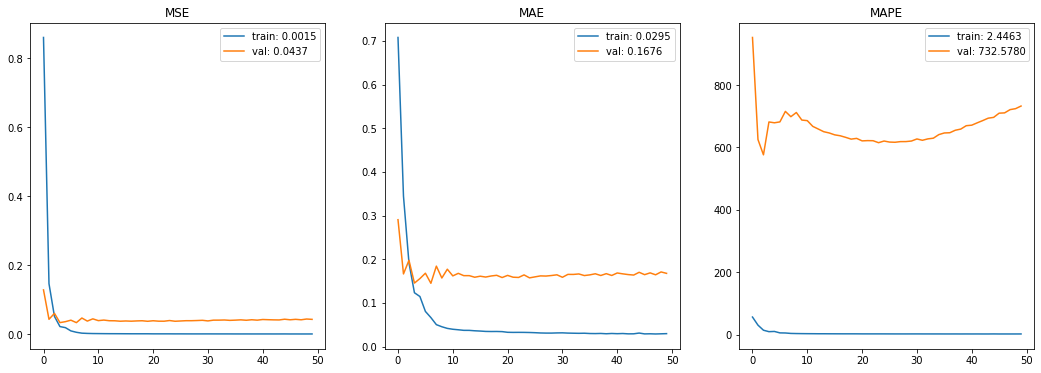

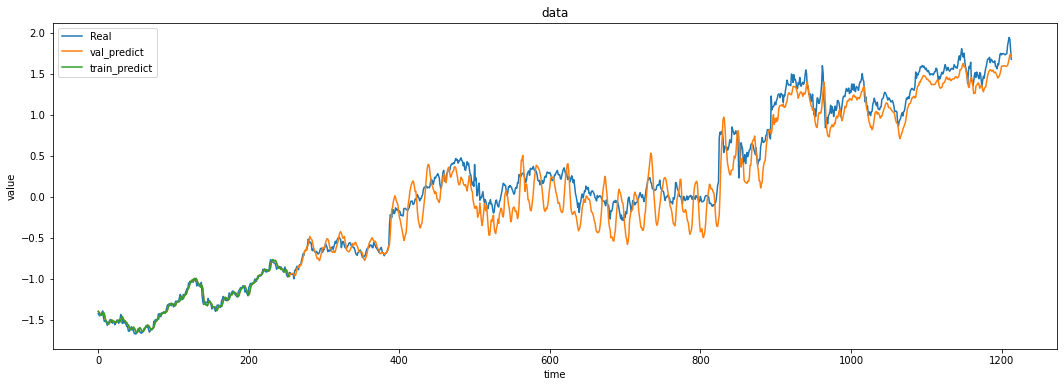

In [317]:
model4 = Sequential(name = 'simplex_model_64')
model4.add(InputLayer((None, 1)))
model4.add(SimpleRNN(64))
model4.add(Dense(1))
model4.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history4 = model4.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history4, model4)

In [318]:
timestamps=50
y_len=1
X_train, y_train = split(data_scaled[:part], timestamps, y_len)
X_val, y_val = split(data_scaled[part-timestamps: ], timestamps, y_len)

**simplex_model_128**

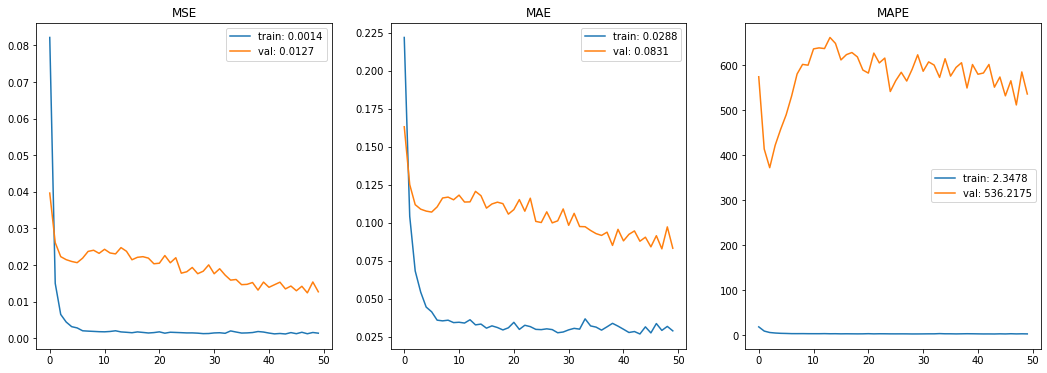

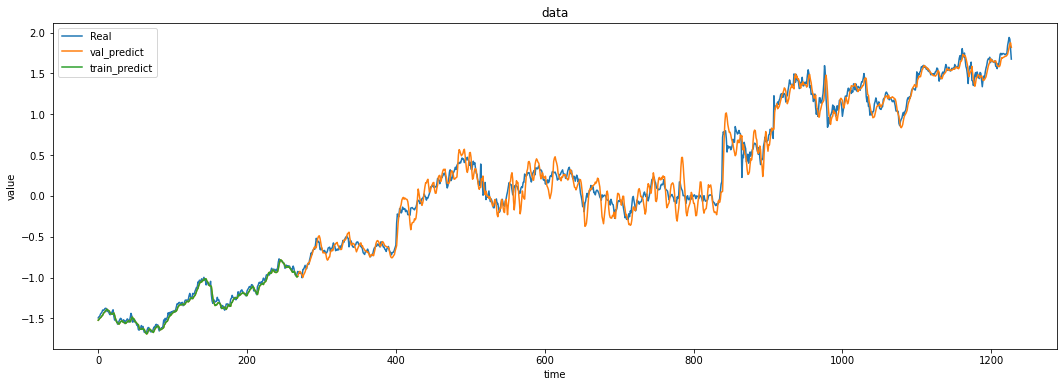

In [319]:
model5 = Sequential(name = 'simplex_model_128')
model5.add(InputLayer((None, 1)))
model5.add(SimpleRNN(128))
model5.add(Dense(1))
model5.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history5 = model5.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history5, model5)

**LSTM_model_32**

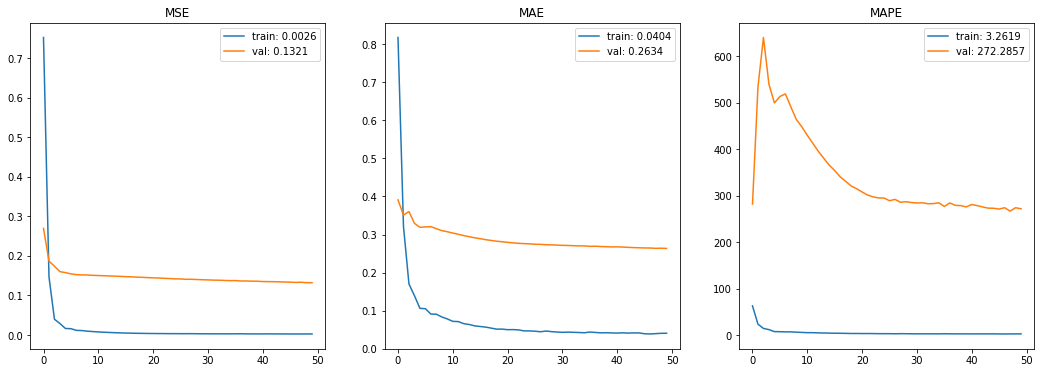

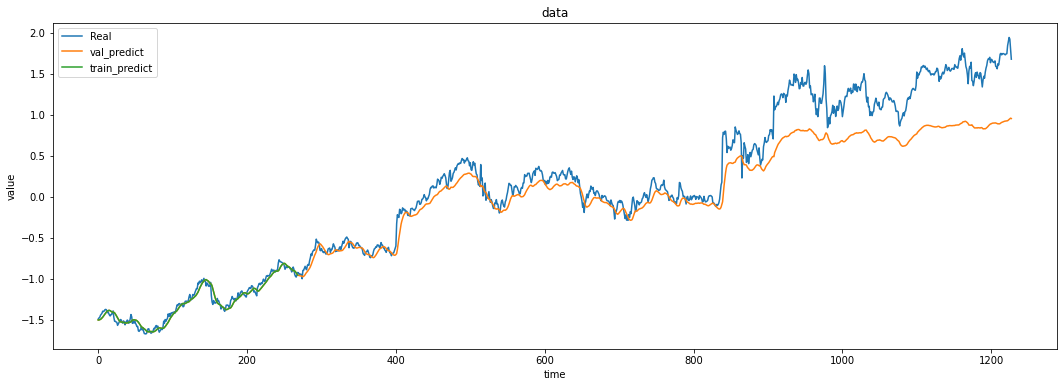

In [320]:
model6 = Sequential(name = 'LSTM_model_32')
model6.add(InputLayer((None, 1)))
model6.add(LSTM(32))
model6.add(Dense(1))
model6.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history6 = model6.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history6, model6)

**LSTM_model_64**

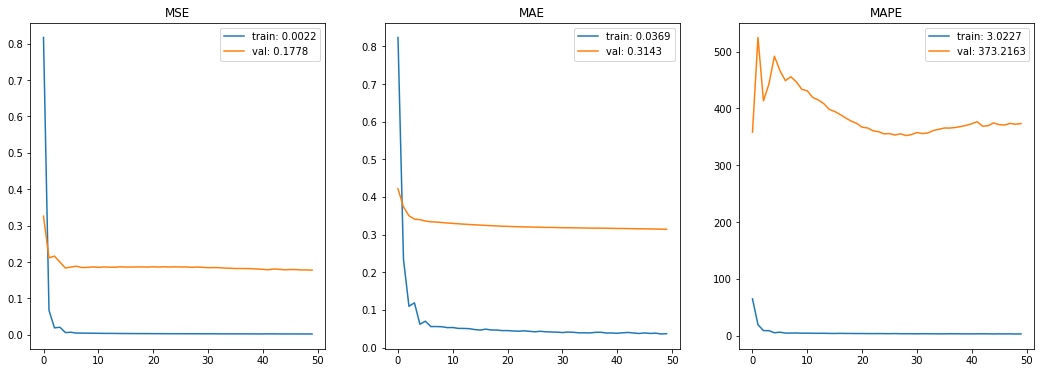

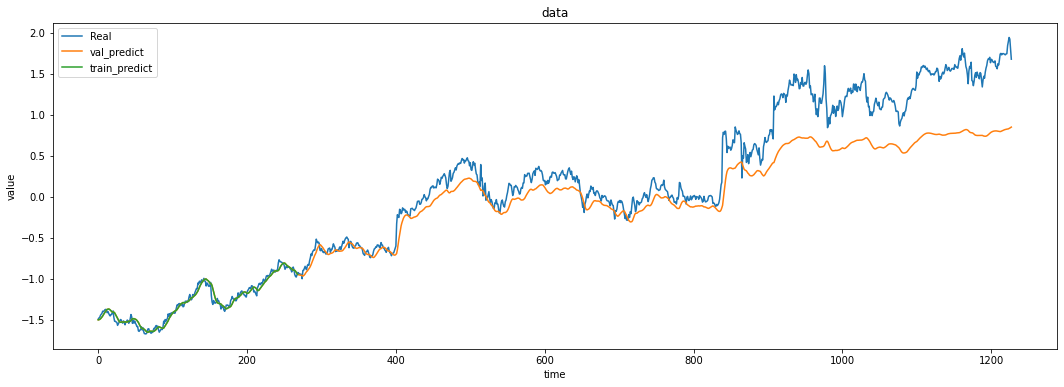

In [321]:
model7 = Sequential(name = 'LSTM_model_64')
model7.add(InputLayer((None, 1)))
model7.add(LSTM(64))
model7.add(Dense(1))
model7.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history7 = model7.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history7, model7)

**LSTM_model_128**

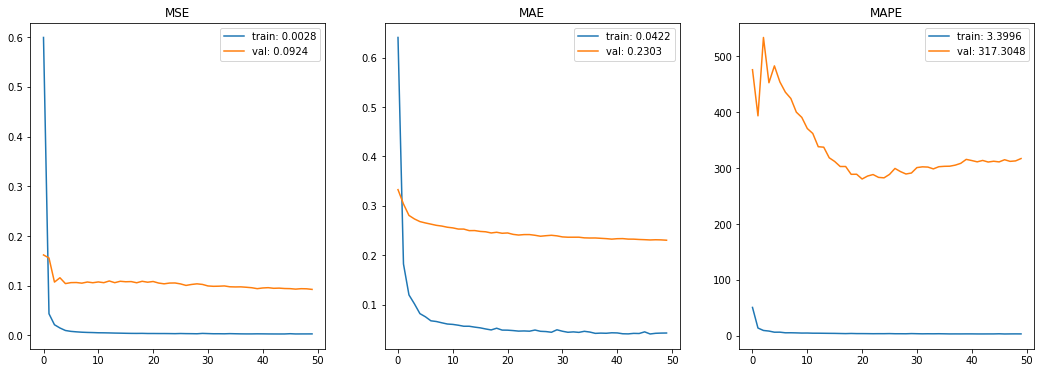

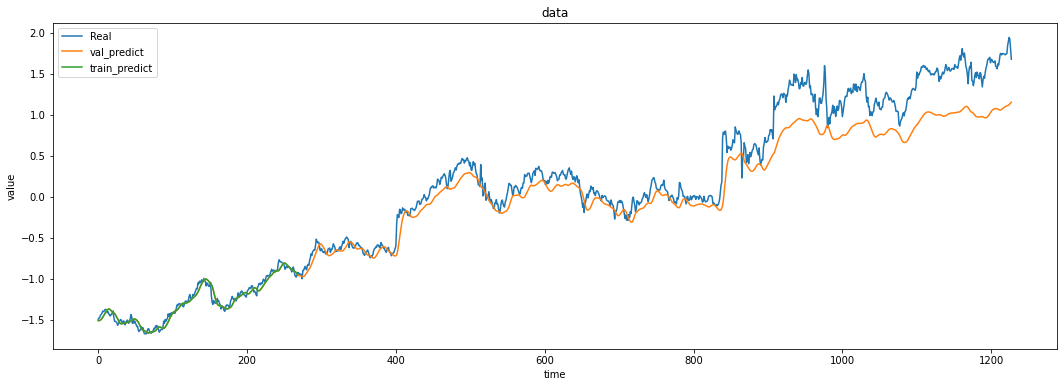

In [322]:
model8 = Sequential(name = 'LSTM_model_128')
model8.add(InputLayer((None, 1)))
model8.add(LSTM(128))
model8.add(Dense(1))
model8.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history8 = model8.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history8, model8)

**GRU_model_32**

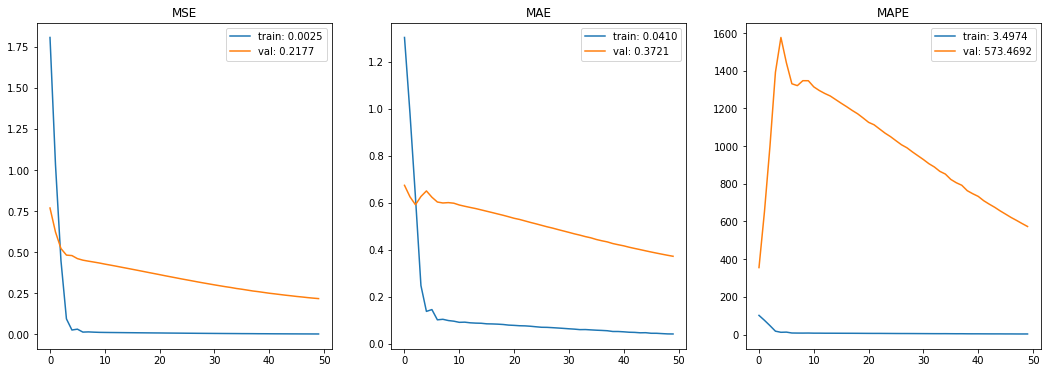

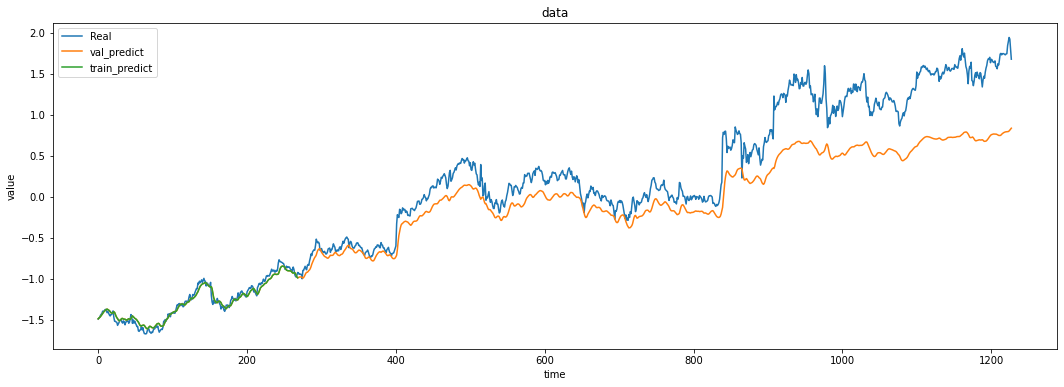

In [323]:
model9 = Sequential(name = 'GRU_model_32')
model9.add(InputLayer((None, 1)))
model9.add(GRU(32))
model9.add(Dense(1))
model9.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history9 = model9.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history9, model9)

**GRU_model_64**

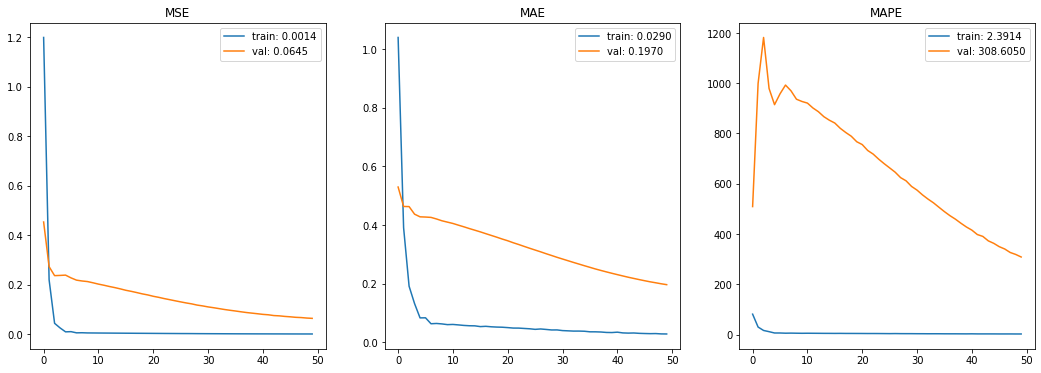

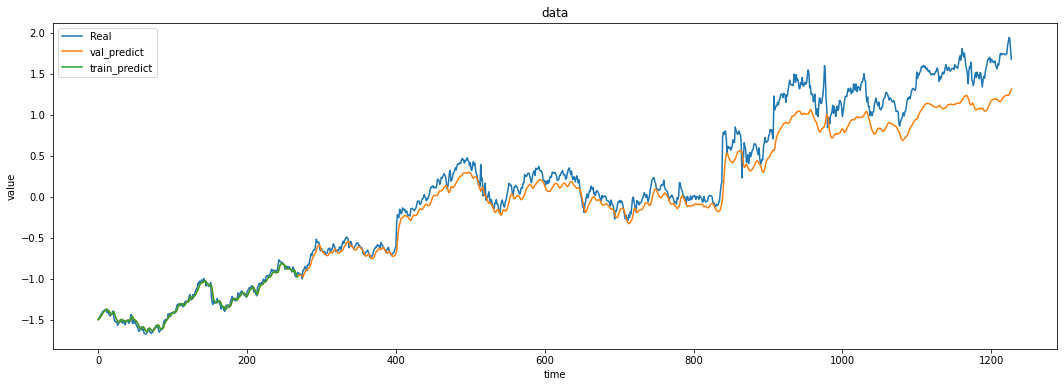

In [324]:
model10 = Sequential(name = 'GRU_model_64')
model10.add(InputLayer((None, 1)))
model10.add(GRU(64))
model10.add(Dense(1))
model10.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history10 = model10.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history10, model10)

**GRU_model_128**

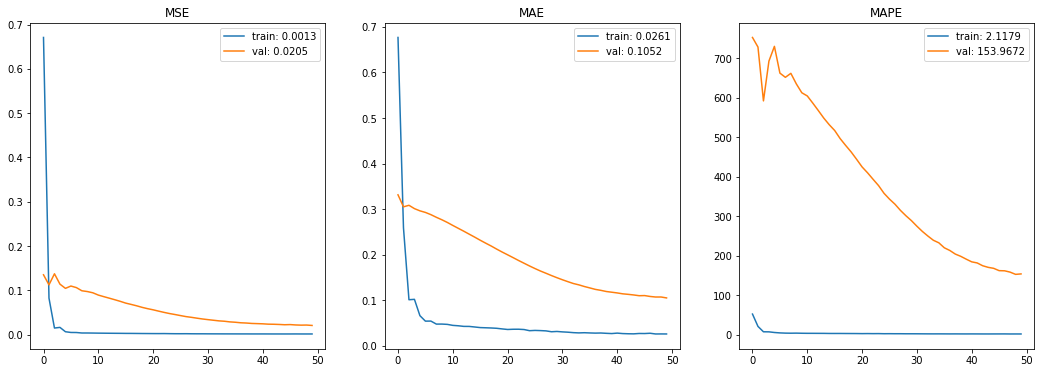

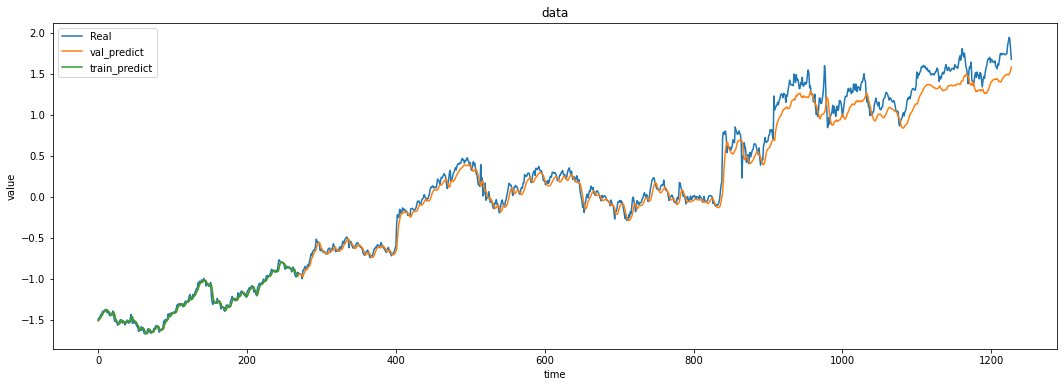

In [325]:
model11 = Sequential(name = 'GRU_model_128')
model11.add(InputLayer((None, 1)))
model11.add(GRU(128))
model11.add(Dense(1))
model11.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history11 = model11.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history11, model11)

**GRU_model_256**

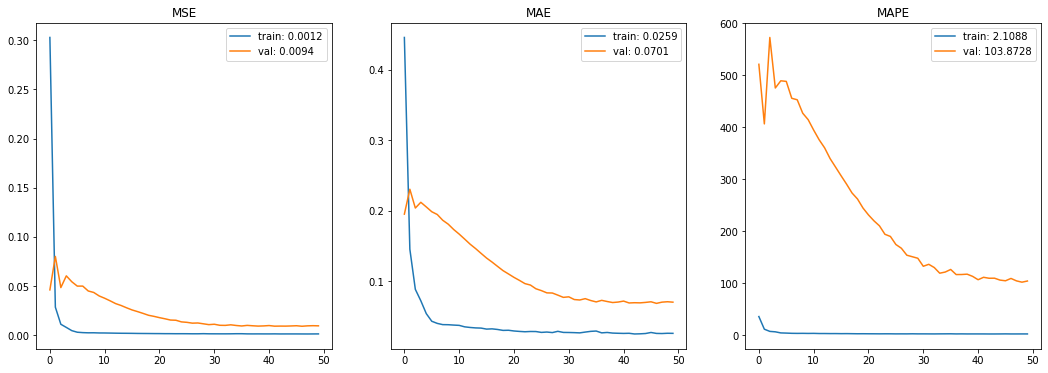

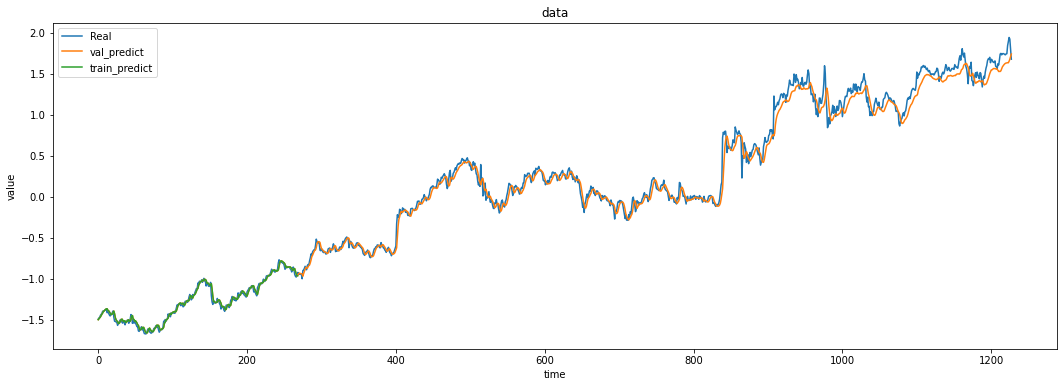

In [326]:
model12 = Sequential(name = 'GRU_model_256')
model12.add(InputLayer((None, 1)))
model12.add(GRU(256))
model12.add(Dense(1))
model12.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history12 = model12.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history12, model12)

Побудувати i навчити глибоку модель з декiлькома рекурентними шарами
LSTM, а також глибоку модель з декiлькома шарами GRU.

**LSTM**

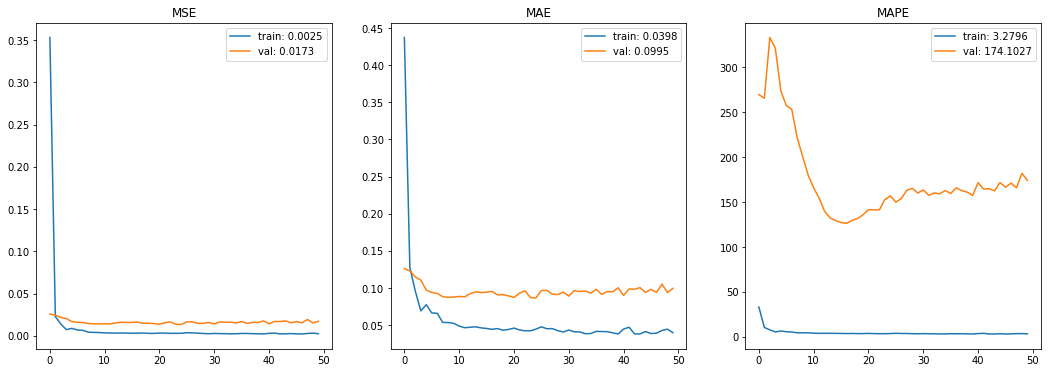

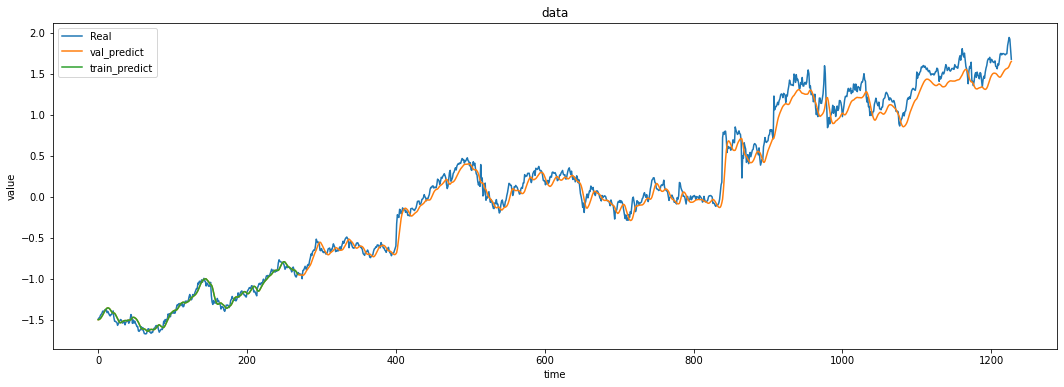

In [327]:
model13 = Sequential(name = 'LSTM_model_2_256')
model13.add(InputLayer((None, 1)))
model13.add(LSTM(256, return_sequences=True))
model13.add(LSTM(256))
model13.add(Dense(1))
model13.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history13 = model13.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history13, model13)

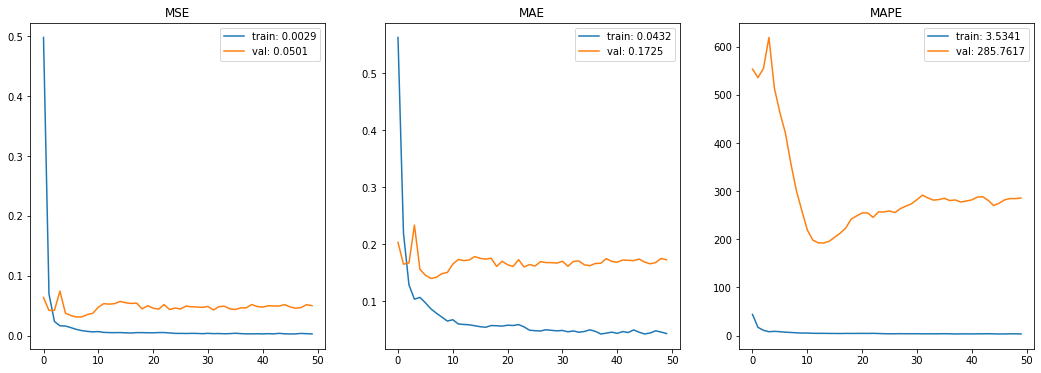

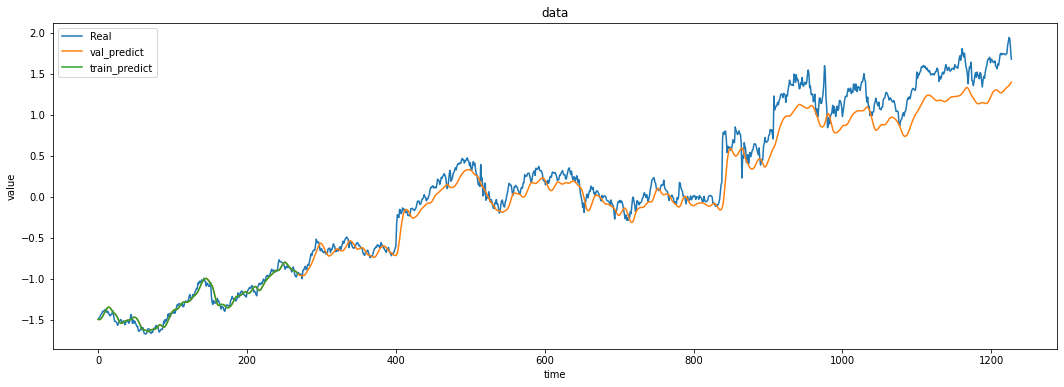

In [328]:
model14 = Sequential(name = 'LSTM_model_3_256')
model14.add(InputLayer((None, 1)))
model14.add(LSTM(256, return_sequences=True))
model14.add(LSTM(256, return_sequences=True))
model14.add(LSTM(256))
model14.add(Dense(1))
model14.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history14 = model14.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history14, model14)

**GRU**

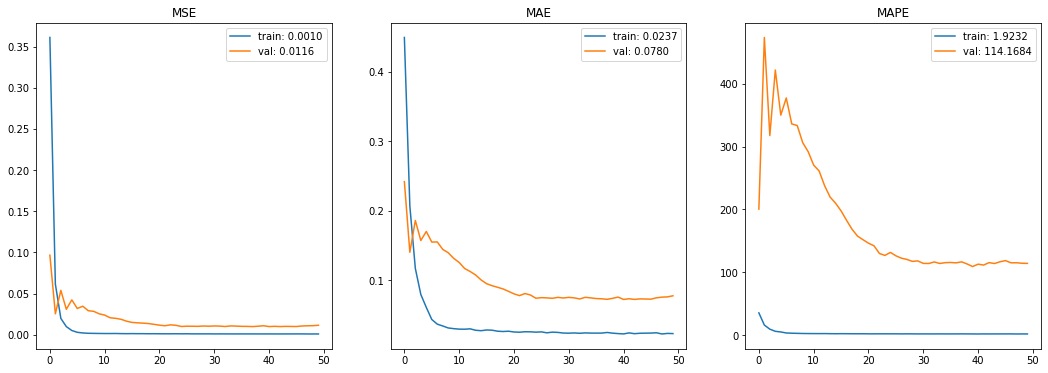

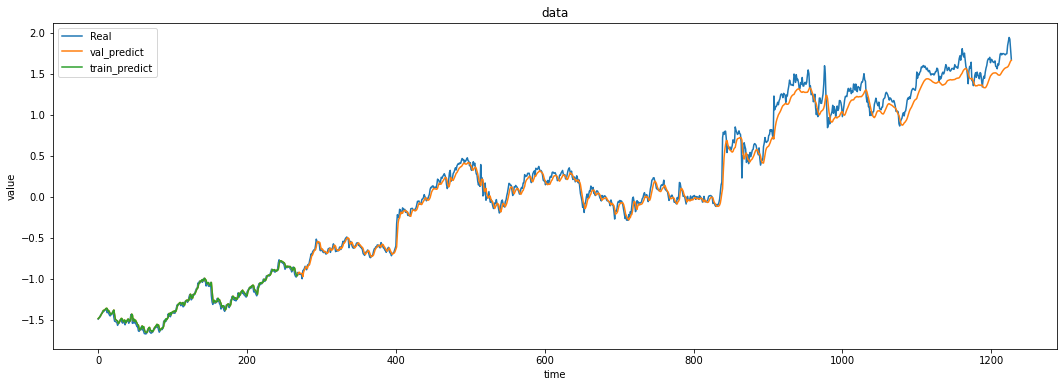

In [329]:
model15 = Sequential(name = 'GRU_model_2_256')
model15.add(InputLayer((None, 1)))
model15.add(GRU(256, return_sequences=True))
model15.add(GRU(256))
model15.add(Dense(1))
model15.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history15 = model15.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history15, model15)

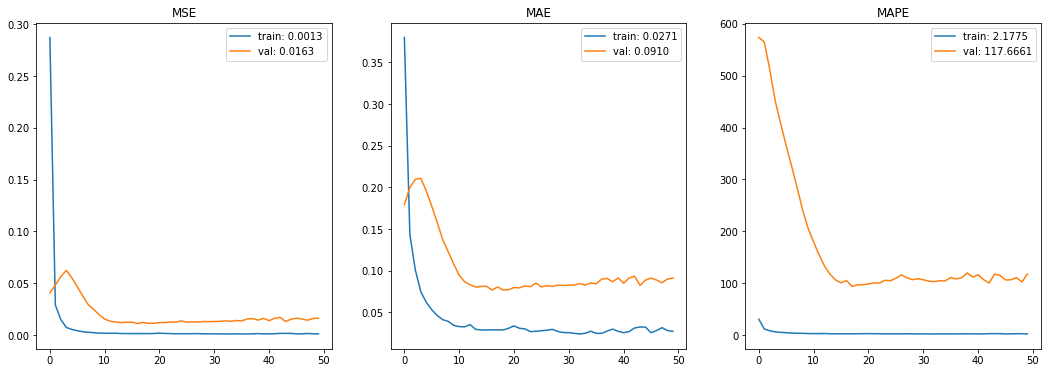

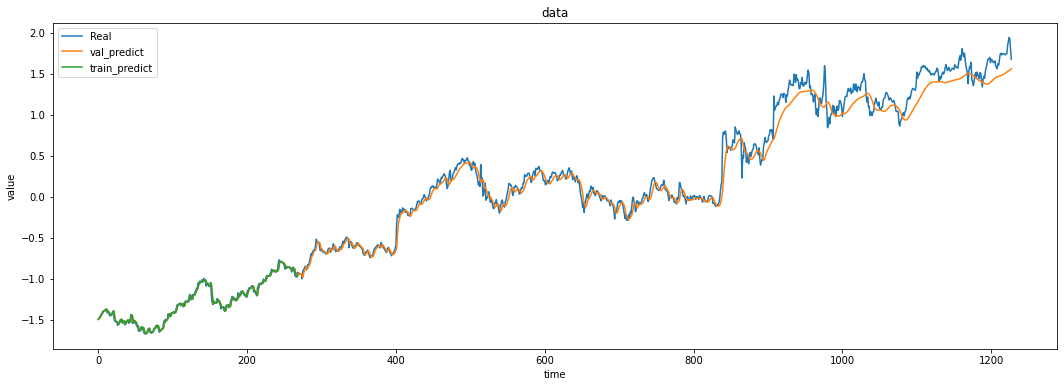

In [330]:
model16 = Sequential(name = 'GRU_model_3_256')
model16.add(InputLayer((None, 1)))
model16.add(GRU(256, return_sequences=True))
model16.add(GRU(256, return_sequences=True))
model16.add(GRU(256))
model16.add(Dense(1))
model16.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history16 = model16.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history16, model16)

Дропауты

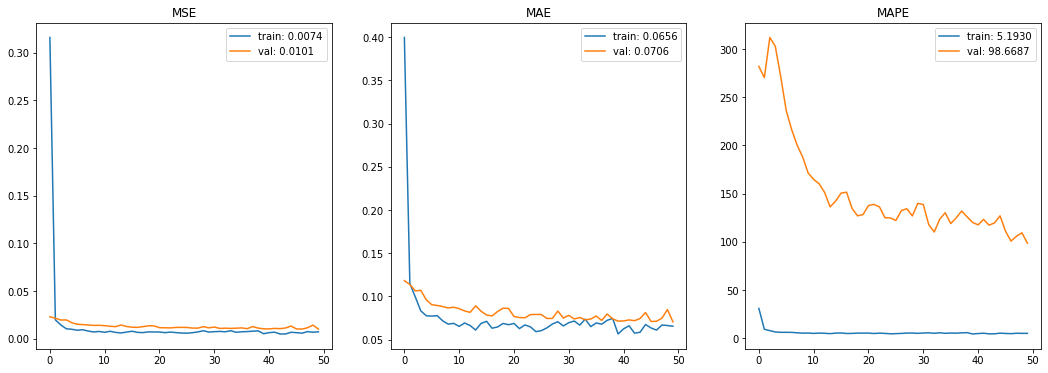

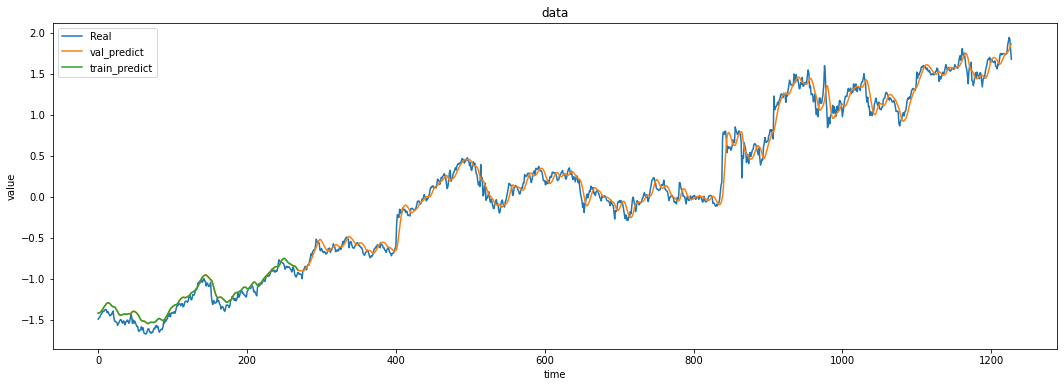

In [335]:
model17 = Sequential(name = 'LSTM_model_2_256_drop')
model17.add(InputLayer((None, 1)))
model17.add(LSTM(256, return_sequences=True))
model17.add(Dropout(0.2))
model17.add(LSTM(256))
model17.add(Dropout(0.2))
model17.add(Dense(1))
model17.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history17 = model17.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history17, model17)

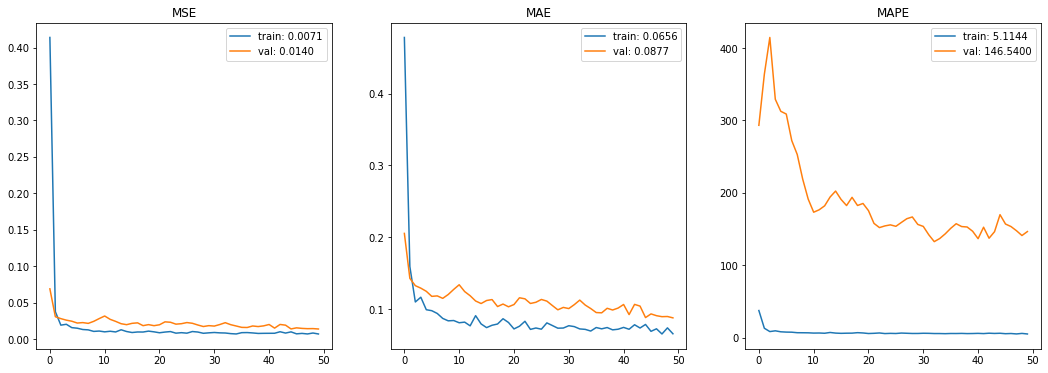

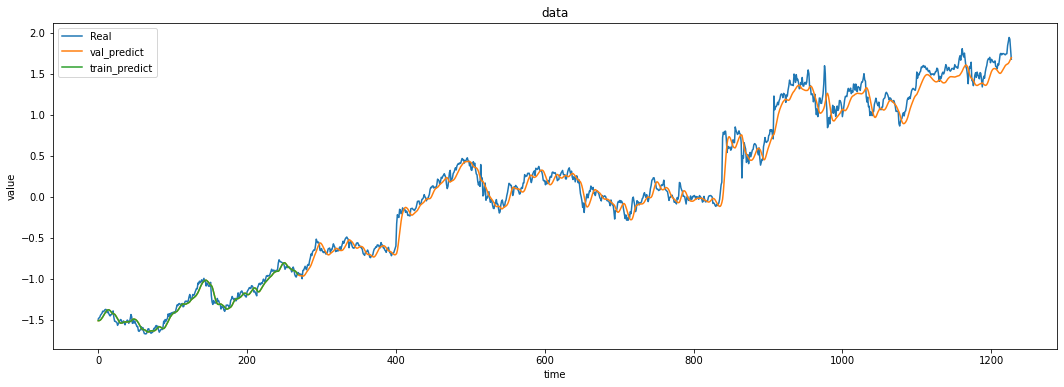

In [343]:
model18 = Sequential(name = 'LSTM_model_2_256_128_drop')
model18.add(InputLayer((None, 1)))
model18.add(LSTM(256, return_sequences=True))
model18.add(Dropout(0.2))
model18.add(LSTM(128))
model18.add(Dropout(0.2))
model18.add(Dense(1))
model18.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history18 = model18.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history18, model18)

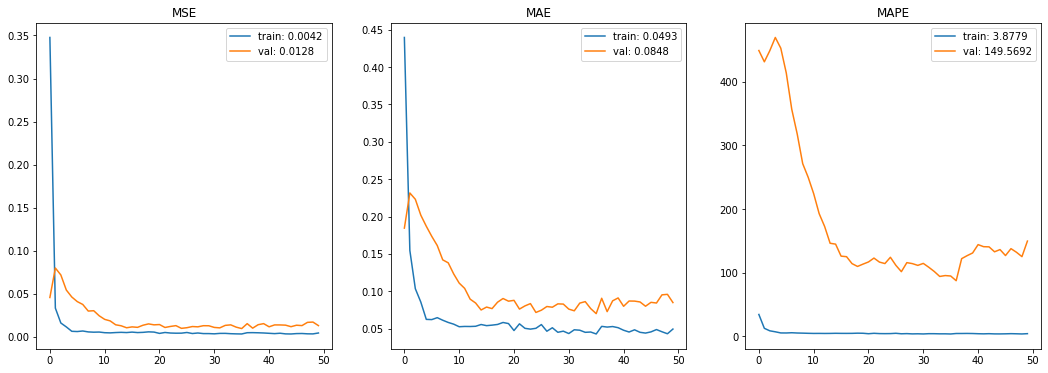

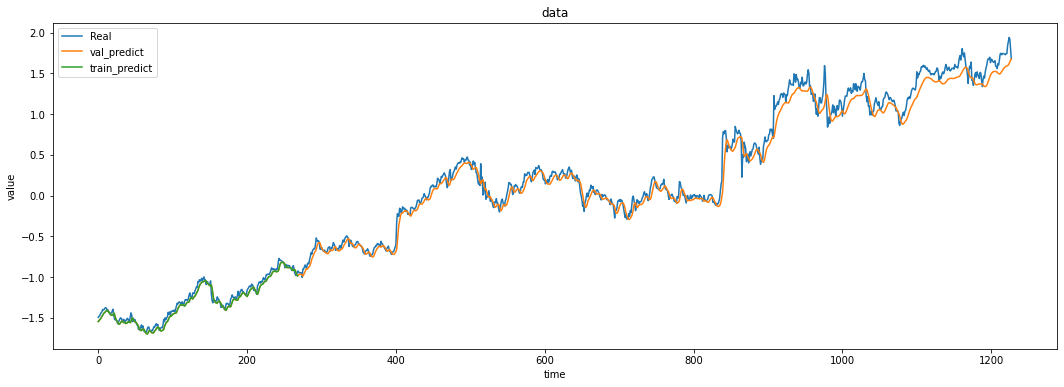

In [346]:
model19 = Sequential(name = 'GRU_model_3_256_drop')
model19.add(InputLayer((None, 1)))
model19.add(GRU(256, return_sequences=True))
model19.add(Dropout(0.1))
model19.add(GRU(256, return_sequences=True))
model19.add(Dropout(0.1))
model19.add(GRU(256))
model19.add(Dropout(0.1))
model19.add(Dense(1))
model19.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history19 = model19.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history19, model19)

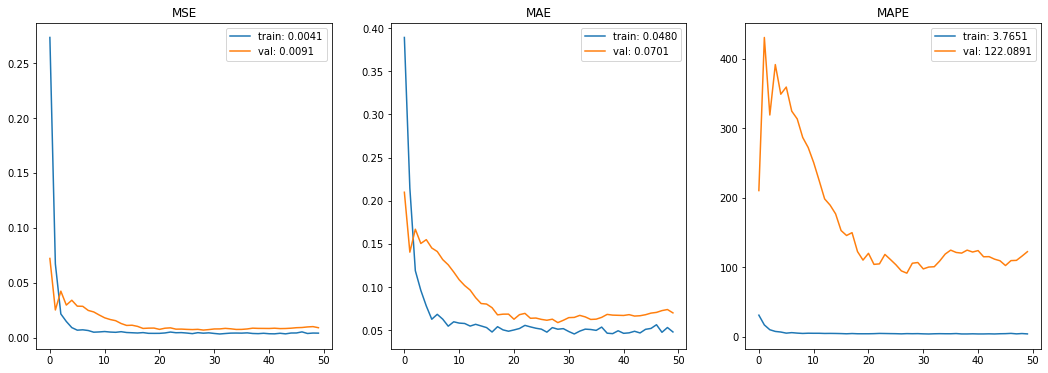

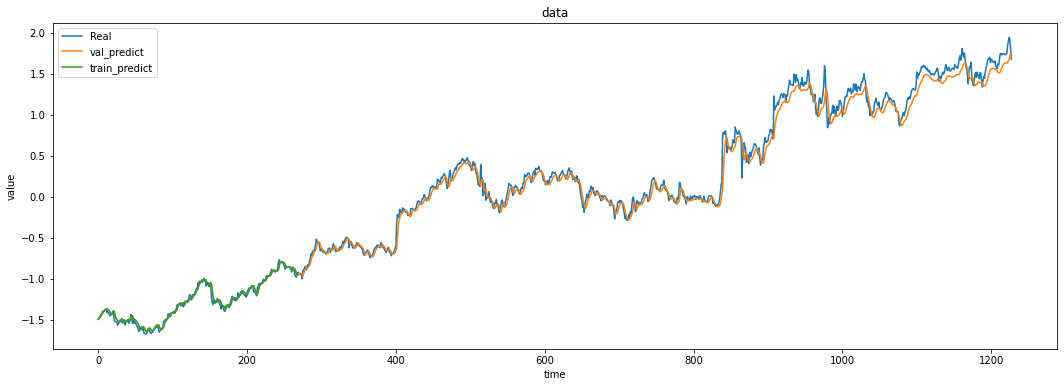

In [349]:
model20 = Sequential(name = 'GRU_model_2_256_128_drop')
model20.add(InputLayer((None, 1)))
model20.add(GRU(256, return_sequences=True))
model20.add(Dropout(0.1))
model20.add(GRU(128))
model20.add(Dropout(0.1))
model20.add(Dense(1))
model20.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[ MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history20 = model20.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, verbose=0)
res(history20, model20)

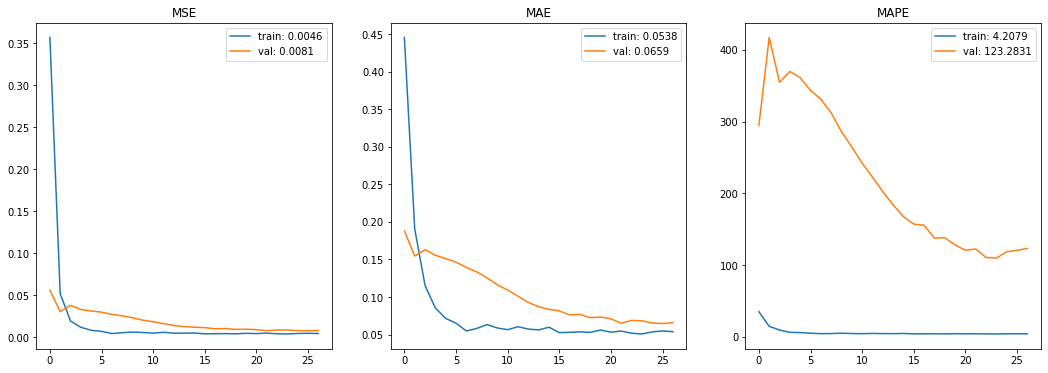

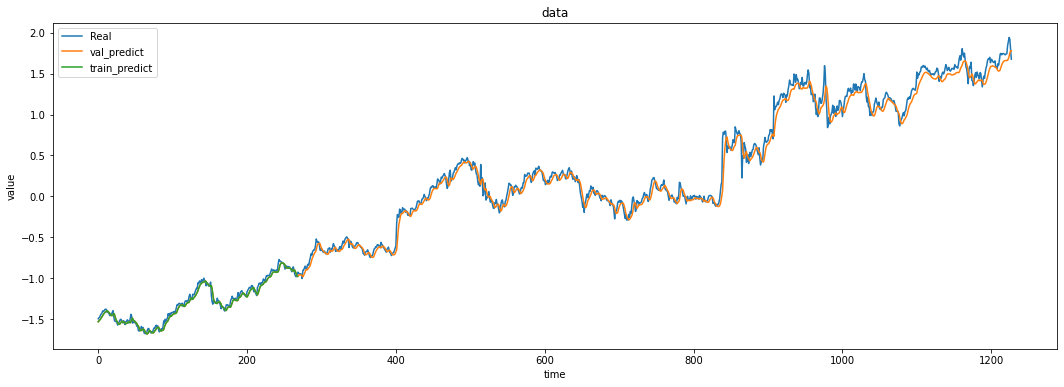

In [356]:
model21 = Sequential(name = 'GRU_model_2_256_64_drop')
model21.add(InputLayer((None, 1)))
model21.add(GRU(256, return_sequences=True))
model21.add(Dropout(0.1))
model21.add(GRU(128))
model21.add(Dropout(0.1))
model21.add(Dense(1))
model21.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history21 = model21.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=27, verbose=0)
res(history21, model21)

**Conv1D**

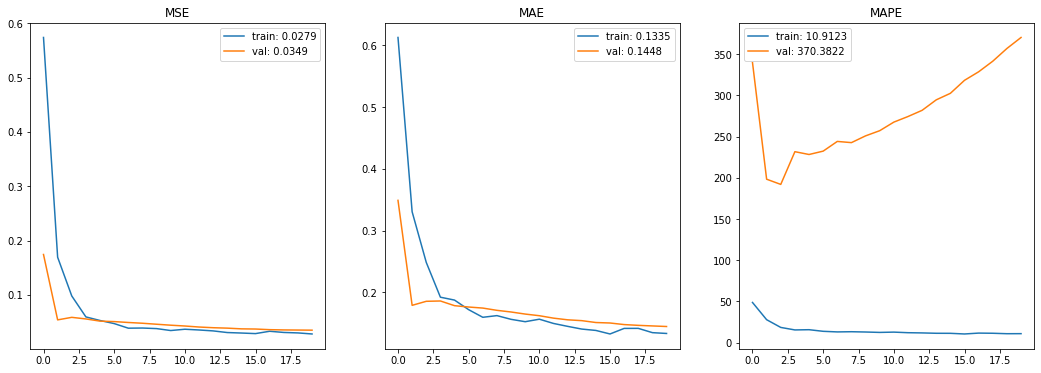

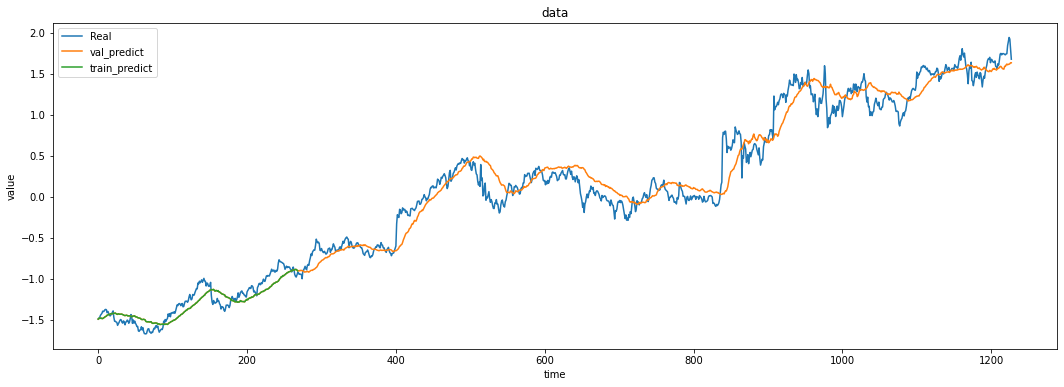

In [369]:
model22 = Sequential(name = 'Conv1D_model')
model22.add(InputLayer((50, 1)))
model22.add(Conv1D(32, 5, 1, padding='same', activation='tanh'))
model22.add(MaxPool1D(2))
model22.add(Dropout(0.1))
model22.add(Conv1D(32, 5, 1, padding='same', activation='tanh'))
model22.add(MaxPool1D(2))
model22.add(Dropout(0.1))
model22.add(Flatten())
model22.add(Dense(1))
model22.compile(loss = MeanSquaredError(name='mse'), optimizer = Adam(), metrics=[MeanAbsoluteError(name='mae'), MeanAbsolutePercentageError(name = 'mape')])
with tf.device('/device:GPU:0'):
  history22 = model22.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=20, verbose=0)
res(history22, model22)

**Побудувати часткову автокореляцiйну функцiю ряду**

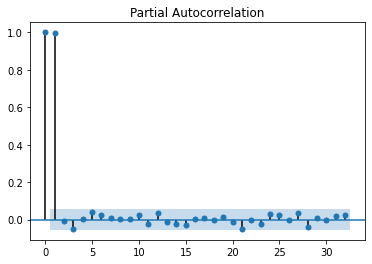

In [373]:
plot_pacf(data);

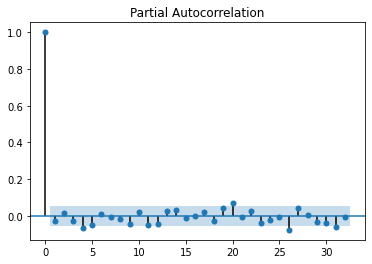

In [374]:
plot_pacf(data.diff()[1:]);

In [375]:
model21.save('drive/MyDrive/GRU')

INFO:tensorflow:Assets written to: drive/MyDrive/GRU/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GRU/assets
